In [1]:
SMPLSH_Dir = r'..\SMPL_Socks\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch
import numpy as np

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    HardPhongShader,
    BlendParams
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [3]:
smplshData = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SmplshModel.npz'

In [4]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

pose_size = 3 * 52
beta_size = 10

smplsh = smplsh_torch.SMPLModel(device, smplshData)
np.random.seed(9608)
pose = torch.from_numpy((np.random.rand(pose_size) - 0.5) * 0.4)\
        .type(torch.float64).to(device)
betas = torch.from_numpy((np.random.rand(beta_size) - 0.5) * 0.06) \
        .type(torch.float64).to(device)
trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)

verts = smplsh(betas, pose, trans).type(torch.float32)
# Initialize each vertex to be white in color.
verts_rgb = ( 0.5 *torch.ones_like(verts))[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

smplshMesh = Meshes([verts], [smplsh.faces.to(device)], textures=textures)

# # Load obj file
# mesh = load_objs_as_meshes([obj_filename], device=device)
# texture_image=mesh.textures.maps_padded()

In [5]:
device

device(type='cuda', index=0)

In [1]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size=512, 
    # blur_radius=0.00, 
    blur_radius=0.0005, 
    faces_per_pixel=1, 
    bin_size=0
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
    # shader=SoftSilhouetteShader(
    #     blend_params=blend_params
    #     # device=device, 
    #     # cameras=cameras,
    #     # lights=lights
    # )
)

NameError: name 'look_at_view_transform' is not defined

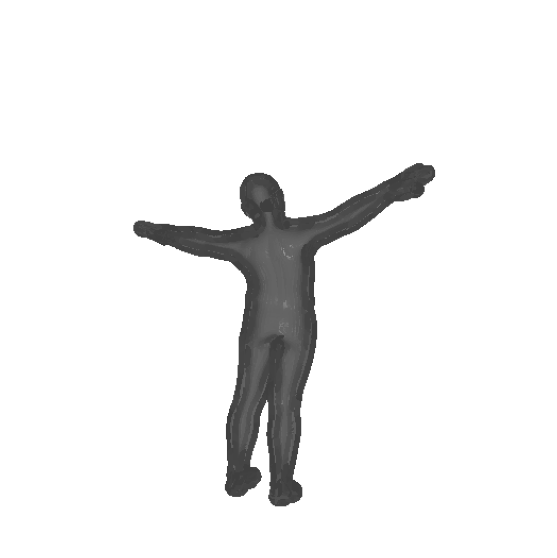

In [15]:
images = renderer(smplshMesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [16]:
images.shape

torch.Size([1, 512, 512, 4])

In [17]:
targetImg = images[0, ..., :3]

In [18]:
posePerturbed = torch.tensor(pose.cpu().numpy() + (np.random.rand(pose_size) - 0.5) * 0.2, dtype=torch.float64, device=device, requires_grad=T)
        

torch.randn()

posePerturbed.requires_grad = True

In [19]:
vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)


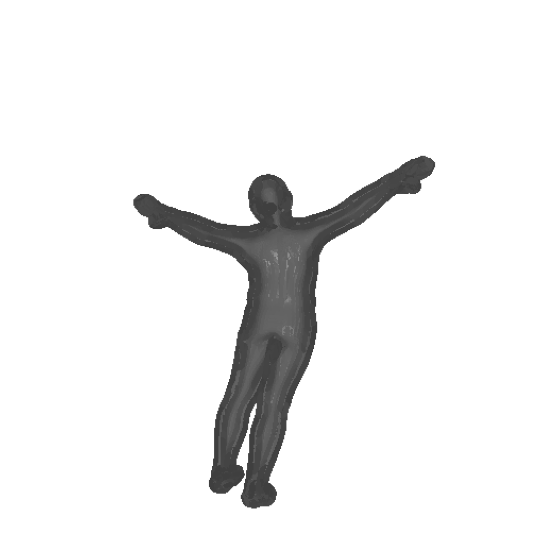

In [20]:
images = renderer(smplshMeshPerturbed)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().detach().numpy())
plt.grid("off");
plt.axis("off");

In [21]:
# class Model(nn.Module):
#     def __init__(self, meshes, renderer, image_ref, pose, R, T):
#         super().__init__()
#         self.meshes = meshes
#         self.device = meshes.device
#         self.renderer = renderer
#         
#         self.R = R
#         self.T = T
#         
#         # Get the silhouette of the reference RGB image by finding all the non zero values. 
#         image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 0).astype(np.float32))
#         self.register_buffer('image_ref', image_ref)
#         
#         # Create an optimizable parameter for the x, y, z position of the camera. 
#         self.pose = nn.Parameter(pose)
# 
#     def forward(self):
#         
#         # Render the image using the updated camera position. Based on the new position of the 
#         # camer we calculate the rotation and translation matrices
#         # R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
#         # T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
#         
#         image = self.renderer(meshes_world=self.meshes.clone(), R=self.R, T=self.T)
#         
#         # Calculate the silhouette loss
#         loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
#         return loss, image

In [22]:
loss = torch.sum((targetImg[..., :3] - images[..., :3]) ** 2)


In [23]:
optimizer = torch.optim.Adam([posePerturbed], lr=0.00001)

In [4]:
loop = tqdm_notebook(range(1000))
for i in loop:
    loop.set_description('Optimizing (loss %.4f)' % (i / 1000))

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [4]:
i

0

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

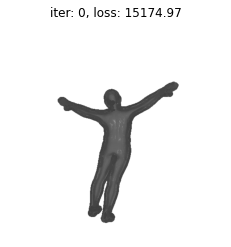

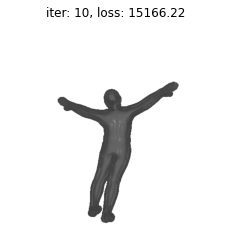

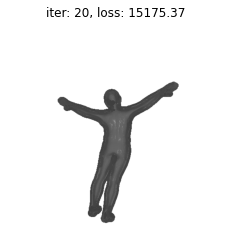

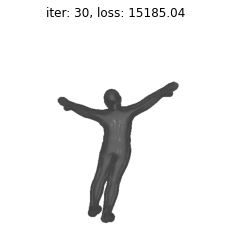

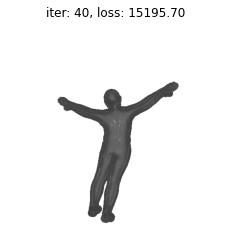

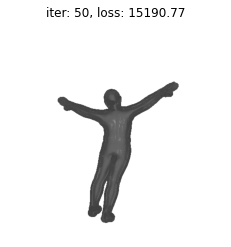

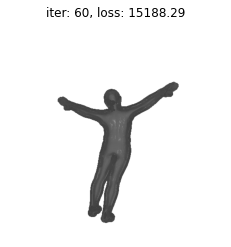

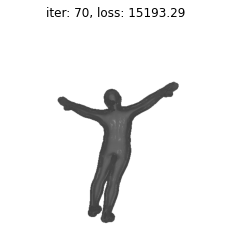

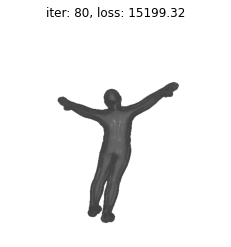

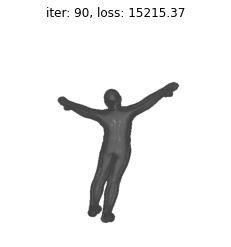

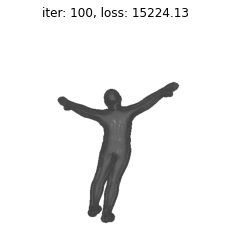

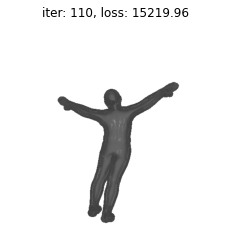

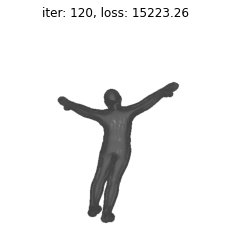

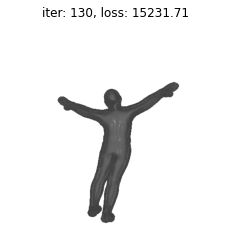

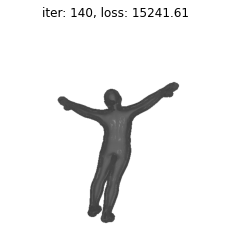

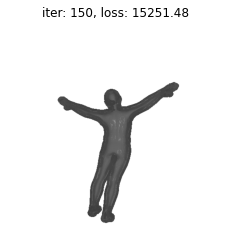

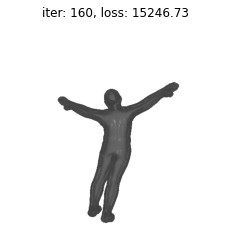

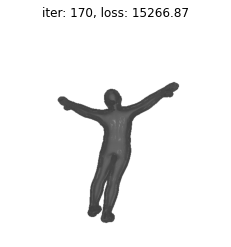

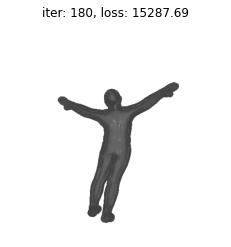

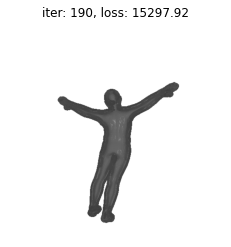

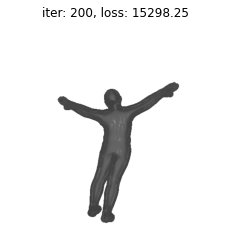

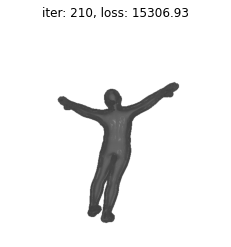

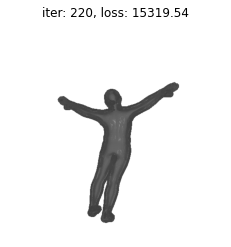

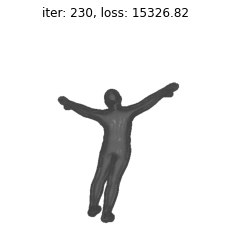

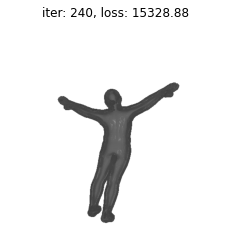

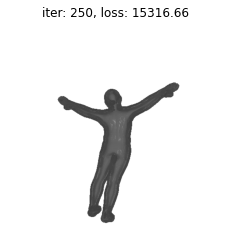

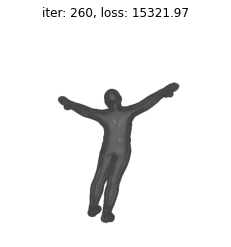

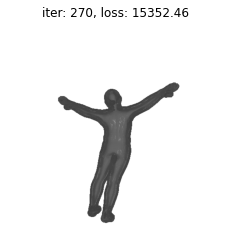

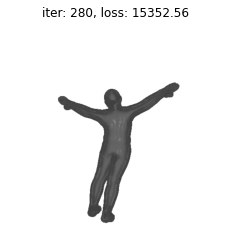

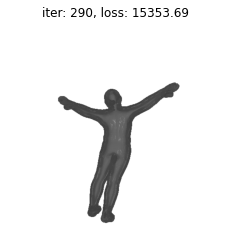

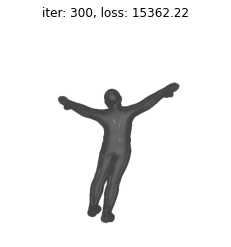

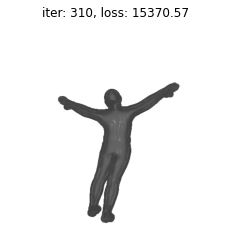

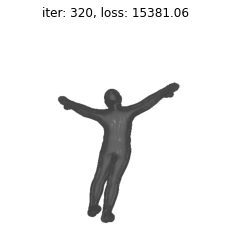

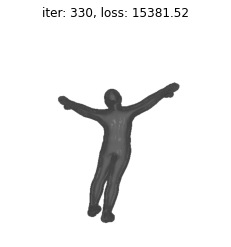

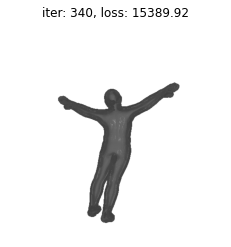

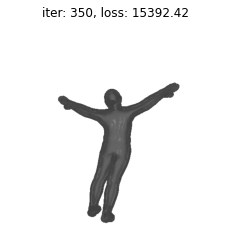

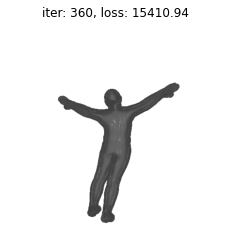

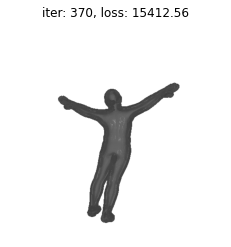

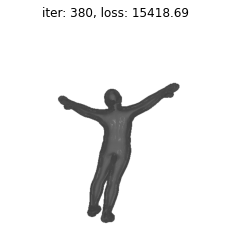

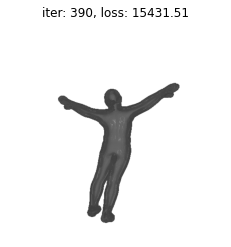

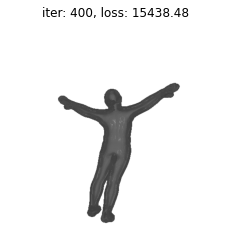

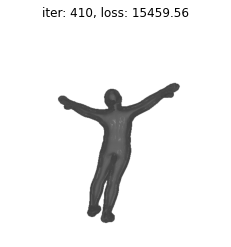

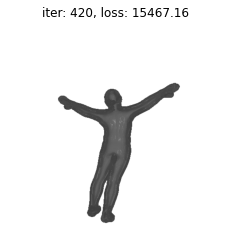

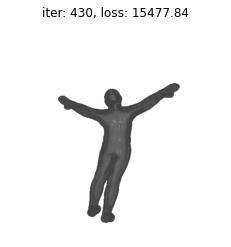

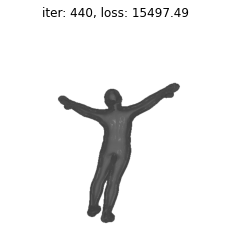

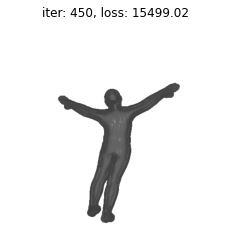

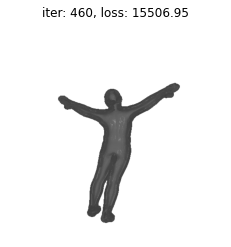

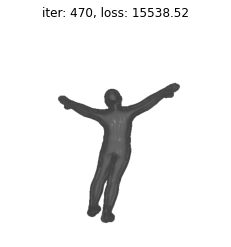

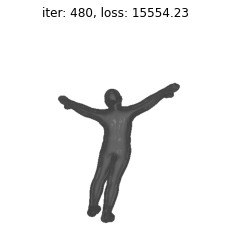

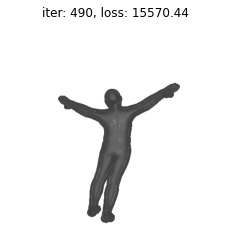

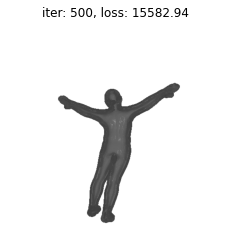

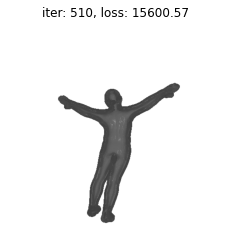

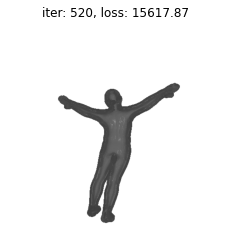

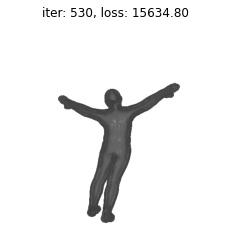

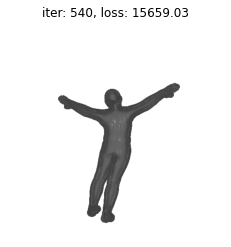

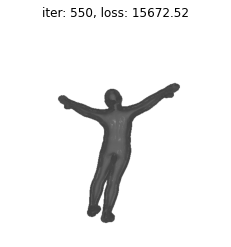

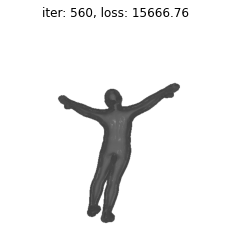

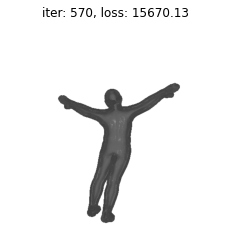

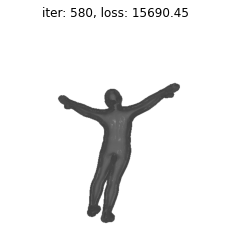

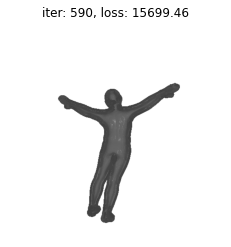

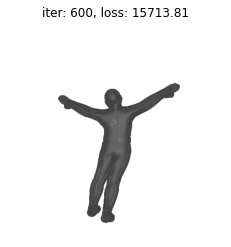

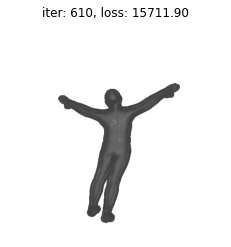

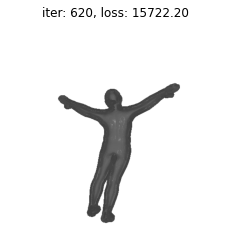

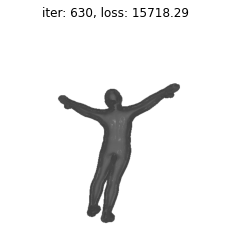

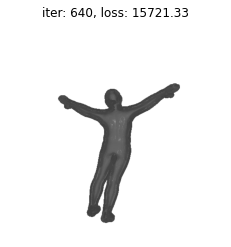

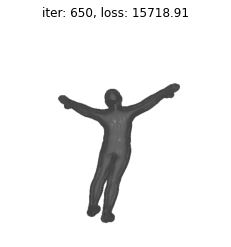

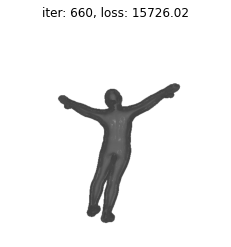

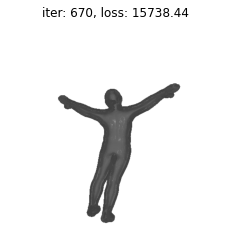

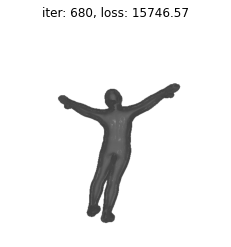

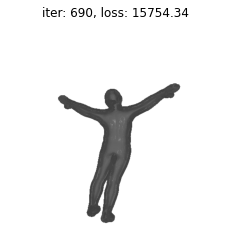

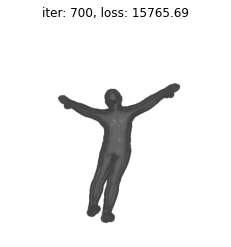

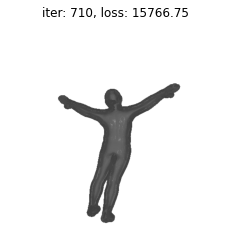

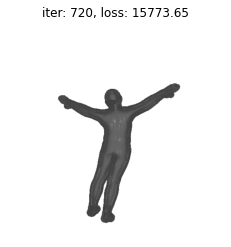

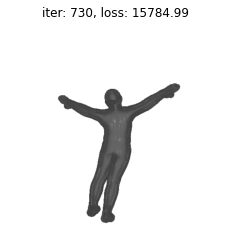

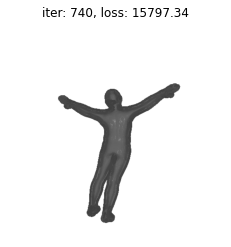

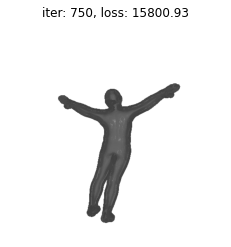

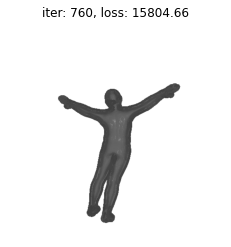

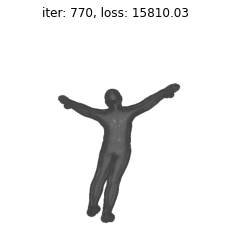

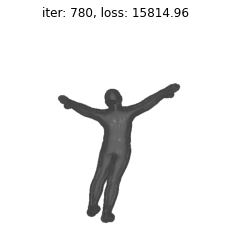

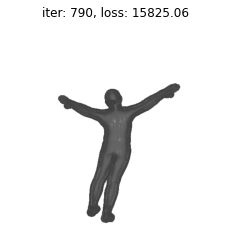

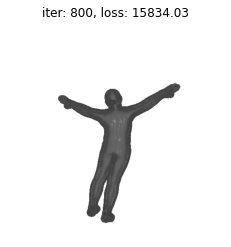

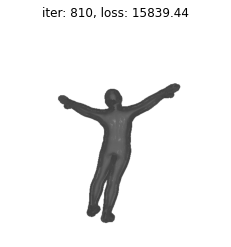

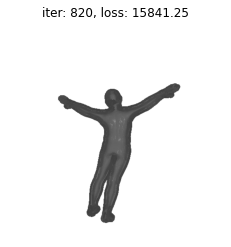

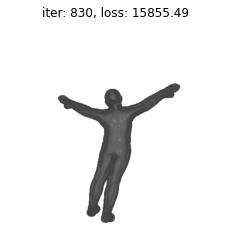

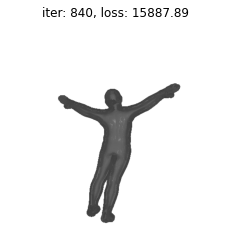

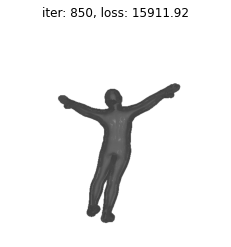

In [24]:
loop = tqdm_notebook(range(1000))
for i in loop:
    optimizer.zero_grad()
    
    vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
    smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)
    
    images = renderer(smplshMeshPerturbed)
    # targetImg = images[0, ..., :3]
    loss = torch.sum((targetImg[..., :3] - images[..., :3]) ** 2)
    # loss, _ = model()
    
    
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    # if loss.item() < 200:
    #     break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        # R = look_at_rotation(model.camera_position[None, :], device=model.device)
        # T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        # image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        # image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        # image = img_as_ubyte(image)
        # writer.append_data(image)
        
        plt.figure()
        plt.imshow(images[0, ..., :3].cpu().detach().numpy())
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
# writer.close()